# Investigate the Effects of Lockdowns on COVID-19 Cases

## 1. Abstract

The longer the COVID-19 pandemic takes, the more people doubt whether a lockdown effects the number of COVID-19 cases. Because for example many people think that workplaces are one of the major places to get infected and these locations (like open-plan offices) are not regulated by the government during a lockdown. This experiment aims to show which locations are the major reasons for increasing COVID-19 cases in Austria.

## 2. Used Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sn
import matplotlib.pyplot as plt

## 3. The Data

For this experiment I used two datasets 'Daily COVID-19 Cases in Austria' and 'COVID-19: Google Mobility Trends of Austria'.

### 3.1 Daily COVID-19 Cases in Austria

This dataset includes the daily number of COVID-19 cases in Austria from the 26th February 2020 until the 13th April 2021. I downloaded this dataset from https://de.statista.com with the statistic-ID 1150777 (status as of 14th April 2021).

In [18]:
covid_cases = pd.read_excel(r'raw_data/statistic_id1150777.xlsx',
                            sheet_name='Daten',
                            usecols = [1,2],
                            names = ['date','num_cases'],
                            skiprows = [0,1,2,3]
                           )
print(covid_cases.shape)
covid_cases.head()
#covid_cases.describe()

(413, 2)


,date,num_cases
0,26. Feb '20,1
1,27. Feb '20,2
2,28. Feb '20,4
3,29. Feb '20,1
4,1. Mrz '20,4


In [3]:
covid_cases.isnull().sum(axis=0)

date         0
num_cases    0
dtype: int64

There are no missing values in this dataset.

### 3.2 COVID-19: Google Mobility Trends of Austria

This dataset includes how the daily number of visitors (or time spent in percent) in categorized places has changed compared to baseline days (the median value for the 5‑week period from January 3 to February 6, 2020) for different countries. The time period is from the 17th February 2020 until the 11th April 2021 and I downloaded it from https://ourworldindata.org/covid-google-mobility-trends (status as of 14th April 2021).

Each high-level category contains many types of places—some might not be obvious. The following table shows just some of the wide range of places included in 2 example categories:

|Parks|Transit stations|
|-----|----------------|
|Public garden|Subway station|
|Castle|Sea port|
|National forest|Taxi stand|
|Camp ground|Highway rest stop|
|Observation deck|Car rental agency|

In [19]:
mobility_data = pd.read_csv('raw_data/changes-visitors-covid.csv')
mobility_data_austria = mobility_data[mobility_data['Entity']=='Austria']
del mobility_data # or mobility_data_austria.is_copy = False
print(mobility_data_austria.shape)
mobility_data_austria.head()
#mobility_data_austria.describe()

(420, 9)


,Entity,Code,Day,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
2469,Austria,AUT,2020-02-17,11.000,9.000,-1.333,9.333,39.667,-1.000
2470,Austria,AUT,2020-02-18,10.250,8.000,-1.000,7.500,39.750,-1.750
2471,Austria,AUT,2020-02-19,9.000,6.800,-0.600,5.800,33.800,-2.400
2472,Austria,AUT,2020-02-20,8.167,5.833,-0.500,5.167,30.333,-2.833
2473,Austria,AUT,2020-02-21,7.143,5.571,-0.286,4.143,27.000,-3.143


In [5]:
mobility_data_austria.isnull().sum(axis=0)

Entity                   0
Code                     0
Day                      0
retail_and_recreation    0
grocery_and_pharmacy     0
residential              0
transit_stations         0
parks                    0
workplaces               0
dtype: int64

Also in this dataset there are no missing values.

## 4. The Experiment

### 4.1 Data Transformation 

Because the columns with the dates are strings and not datetime objects, I transformed the date columns in both datasets into datetime objects.

In [6]:
def col_date_to_datetime(string_date_list):
    date_list = []
    df = pd.DataFrame(data={'shortcut': ['Jan','Feb','Mrz','Apr','Mai','Juni','Juli',
                                         'Aug','Sept','Okt','Nov','Dez'
                                        ],
                            'month_num': [1,2,3,4,5,6,7,8,9,10,11,12]
                           })
    for string_date in string_date_list:
        day = int(string_date.split(' ')[0].replace('.',''))
        month_string = string_date.split(' ')[1]
        month = df[df['shortcut']==month_string]['month_num']
        if(datetime(2020, 12, 31) in date_list):
            year = 2021
        else:
            year = 2020
        date_list.append(datetime(year, month, day))
    return date_list

In [7]:
covid_cases['Day_datetime'] = col_date_to_datetime(covid_cases['date'].values)

In [8]:
mobility_data_austria['Day_datetime'] = mobility_data_austria['Day'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

### 4.2 Concatenate the Datasets

In order to concatenate the two datasets let's choose just these rows with the same dates.

In [9]:
print(covid_cases['Day_datetime'].min())
print(covid_cases['Day_datetime'].max())

2020-02-26 00:00:00
2021-04-13 00:00:00


In [10]:
print(mobility_data_austria['Day_datetime'].min())
print(mobility_data_austria['Day_datetime'].max())

2020-02-17 00:00:00
2021-04-11 00:00:00


This means that the minimum of the column 'Day_dateime' of the combined dataset is the 26th February 2020 and the maximum is the 11th April 2021.

In [11]:
covid_cases = covid_cases[covid_cases['Day_datetime'] >= datetime(2020,2,26)]
covid_cases = covid_cases[covid_cases['Day_datetime'] <= datetime(2021,4,11)]

In [15]:
mobility_data_austria = mobility_data_austria[mobility_data_austria['Day_datetime'] >= datetime(2020,2,26)]
mobility_data_austria = mobility_data_austria[mobility_data_austria['Day_datetime'] <= datetime(2021,4,11)]

In [16]:
print(covid_cases.shape)
print(mobility_data_austria.shape)

(411, 3)
(411, 10)


At the end, there are 411 days, which are included in both dataset.

In [17]:
all_data = pd.DataFrame(data=mobility_data_austria)
all_data['Number of Cases'] = covid_cases['num_cases'].values

After concatenating the two dataset, the following figure shows the daily number of COVID-19 cases in Austria and the categorized COVID-19 mobility trends of Austria over the same time period.

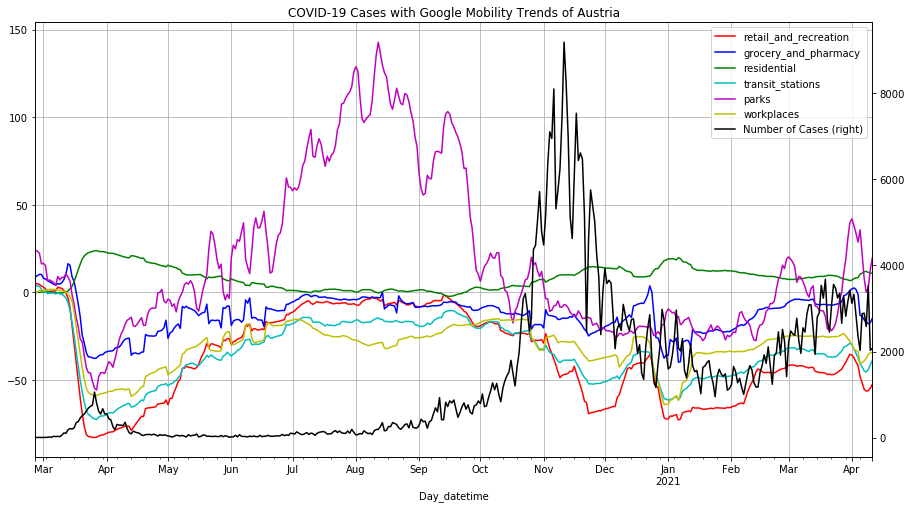

In [33]:
fig, ax = plt.subplots()
all_data.plot(x= 'Day_datetime',
              y= ['retail_and_recreation',
                  'grocery_and_pharmacy',
                  'residential',
                  'transit_stations',
                  'parks',
                  'workplaces'
                 ],
              ax = ax,
              kind='line',
              figsize = (15,8), 
              title="COVID-19 Cases with Google Mobility Trends of Austria",
              grid=True, 
              style = ['r','b','g','c','m','y']
             ) 
all_data.plot(x = 'Day_datetime', 
              y = 'Number of Cases', 
              ax = ax,
              grid=True,
              style = 'k',
              secondary_y = True
             )
plt.savefig('figures/covid_19_cases_with_mobility_trends_of_austria.png')
plt.show()

After the visualiation of the data, I compared the figure with the start and end points of the lockdowns in Austria:

* 16th March 2020 - 14th April 2020: hard lockdown (1st lockdown),
* 14th April 2020 - 17th November 2020: soft lockdown,
* 17th November 2020 - 7th December 2020: hard lockdown (2nd lockdown),
* 7th December 2020 - 26th December 2020: soft lockdown,
* 26th December 2020 - 24th January 2021: hard lockdown (3rd lockdown),
* 24th January 2021 - 1st April 2021: soft lockdown,
* 1st April 2021 - ongoing: hard lockdown (4th lockdown), but just for Vienna, Lower Austria and Burgenland;

At first, the figure shows that people spent more time at home during the 1st, 2nd, 3rd and 4th lockdown. Furthermore, we can see that after the 1st lockdown all categories (except residential) increased until July 2020. Just the category 'parks' increased after July 2020 further up to almost 150 percent over the baseline. So, it seems the major reason for the high number of COVID-19 cases after the summer 2020 (because of the time delay) was that people spent more time outside for example to meet other people in parks, on lakes, on rivers and similar places.

### 4.3 Correlations in the Data

Furthermore, I also created a correlation matrix, which should visualize correlations in the data. But as expected, because of the time delay between high mobility trends and their effects on the number of COVID-19 cases, there are no strong negative or positve correlations between a location and the number of COVID-19 cases.

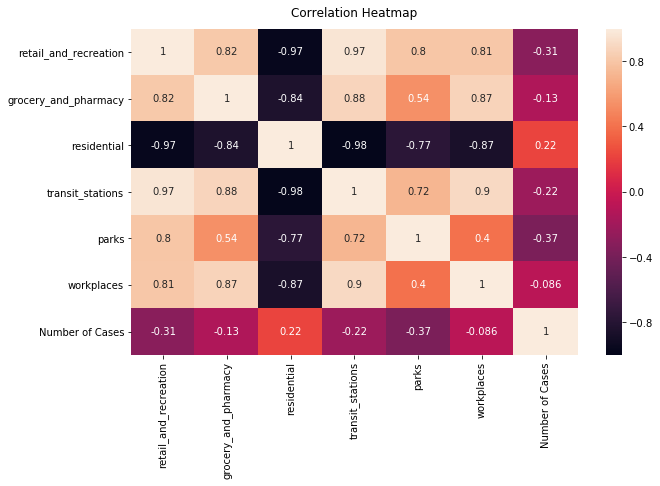

In [34]:
plt.figure(figsize=(10, 6))
heatmap = sn.heatmap(all_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('figures/correlation_heatmap.png')
plt.show()

## 5. Conclusion

At the end, just based on these data it is really hard to find specific locations, which are are the major reasons for increasing COVID-19 cases in Austria. One reason for this is that after the 1st lockdown the mobility trends of all categories (except residential) increased, which caused higher COVID-19 cases (with a time delay) until an exponential growth of the COVID-19 cases. But just because of the reason that the most people are outside during the summer (e.g. in parks, on lakes, on rivers and similar places) and spending less time at workplaces (because of holidays), it's usefull to restrict these situations through curfews. At least until a major part of Austrians were vaccinated.